In [1]:
import numpy as np 
import tensorflow as tf
print(tf.__version__)
import sciann as sn 
import time
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from itertools import product, combinations
import scipy.io
import os

tf.test.gpu_device_name()
%matplotlib inline

2024-07-15 12:11:15.917095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 12:11:16.049282: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 12:11:16.080648: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 12:11:16.572191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

2.10.1
---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.1 
Python Version: 3.8.16 (default, Jun 12 2023, 18:09:05) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


2024-07-15 12:11:19.406380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 12:11:20.061955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 45729 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [2]:
np.random.seed(123)
tf.random.set_seed(123)

#Model specifications

# Computational model parameters

zmin = 0.; zmax = 3.; deltaz = 0.02;
xmin = 0.; xmax = 3.; deltax = 0.02;
deltas = 0.2

# Loading the velocity model
vp = np.load('./over_vp_sigma5.npy')
vs = np.load('./over_vs_sigma5.npy')

vp_true = vp
vs_true = vs
# Point-source locations

sx = 0.
sz = np.round(np.arange(0,3.001,deltas),2);


In [3]:
print(sz.shape)

(16,)


In [4]:
print(vp_true.max(),vp_true.max())
print(vs_true.max(),vs_true.min())
print("taup1 range:",vp_true.min()/vp_true.max(),vp_true.max()/vp_true.min())
print("taus1 range:",vs_true.min()/vs_true.max(),vs_true.max()/vs_true.min())

5.401994493327524 5.401994493327524
3.1225401695534822 1.4445572609710922
taup1 range: 0.4626224748223691 2.161589750657845
taus1 range: 0.4626224748223692 2.1615897506578445


In [5]:
# Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

Z,X,SZ = np.meshgrid(z,x,sz,indexing='ij')

SX = np.ones(SZ.shape)*sx # Creating an array of sources along z with same size as SX
ns = sz.size
# Extending the velocity model in thirs dimension byy repeatin the array
velpmodel = np.repeat(vp[...,np.newaxis],sz.size,axis=2)
velsmodel = np.repeat(vs[...,np.newaxis],sz.size,axis=2)

velpmodel = velpmodel + np.random.uniform(-1,1,size=(velpmodel.shape[0],velpmodel.shape[1],velpmodel.shape[2]))*0.1
velsmodel = velsmodel + np.random.uniform(-1,1,size=(velsmodel.shape[0],velsmodel.shape[1],velsmodel.shape[2]))*0.05

# velpmodel = np.ones([nz,nx,ns], 'float32')*3.0
# velsmodel = np.ones([nz,nx,ns], 'float32')*2.0

X_star = [Z.reshape(-1,1), X.reshape(-1,1), SZ.reshape(-1,1)] # Grid points for prediction

print("nx,nz:",nx,nz)

nx,nz: 151 151


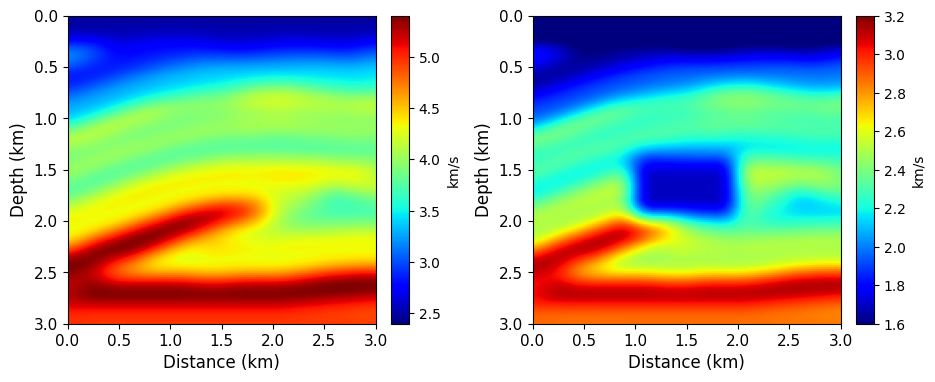

In [6]:
# Plot the velocity model with the source location
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(vp_true, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(2.4,5.4)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(vs_true, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.6,3.2)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./Fig/v_true_over_sigma5.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

In [7]:
iz = np.round(np.arange(0,3.001,0.02),2)
ix = 3.0
iZ,iX,iSZ = np.meshgrid(iz,ix,sz,indexing='ij')
ss1 = [iZ.reshape(-1,1),iX.reshape(-1,1),iSZ.reshape(-1,1)]

In [8]:
num = 20000
rz = np.round(np.random.uniform(zmin, zmax, num), 4).reshape(-1,1)
rx = np.round(np.random.uniform(xmin, xmax, num), 4).reshape(-1,1)
rsz = np.round(np.random.uniform(zmin, zmax, num), 4).reshape(-1,1)

rz = np.append(rz,ss1[0])
rx = np.append(rx,ss1[1]) 
rsz = np.append(rsz, ss1[2])
rsx = np.zeros(rsz.shape)

In [9]:
rz_new = (rsz / deltaz).astype(int)
rx_new = (rsx / deltax).astype(int)

rvelp_list = []
rvels_list = []

for rz_, rx_  in zip(rz_new, rx_new):
    rvelp_list.append(velpmodel[:,:,0][rz_,rx_])
    rvels_list.append(velsmodel[:,:,0][rz_,rx_])
rvelp = np.array(rvelp_list)
rvels = np.array(rvels_list)

In [10]:
T0p = np.sqrt((rz-rsz)**2 + (rx-rsx)**2)/rvelp; 
px0p = np.divide(rx-rsx, T0p*rvelp**2, out=np.zeros_like(T0p),where=T0p!=0)
pz0p = np.divide(rz-rsz, T0p*rvelp**2, out=np.zeros_like(T0p),where=T0p!=0)

T0s = np.sqrt((rz-rsz)**2 + (rx-rsx)**2)/rvels; 
px0s = np.divide(rx-rsx, T0s*rvels**2, out=np.zeros_like(T0s),where=T0s!=0)
pz0s = np.divide(rz-rsz, T0s*rvels**2, out=np.zeros_like(T0s),where=T0s!=0)

In [11]:
indices = np.arange(len(rx) - ss1[1].size, len(rx))
index = np.where(np.isin(np.arange(len(rx)), indices))[0]
# print(index)

In [12]:
Tp_data = np.load('./Tp_data_over_sigma5.npy')
Ts_data = np.load('./Ts_data_over_sigma5.npy')

Tp_data_noi = Tp_data + np.random.randn(Tp_data.shape[0],Tp_data.shape[1],Tp_data.shape[2])*Tp_data.max()*0.0
Ts_data_noi = Ts_data + np.random.randn(Ts_data.shape[0],Ts_data.shape[1],Ts_data.shape[2])*Ts_data.max()*0.0

In [13]:
z_n = ((ss1[0] / deltaz) + 1e-9).astype(int)
x_n = ((ss1[1] / deltax) + 1e-9).astype(int)
sz_n = ((ss1[2] / deltas) + 1e-9).astype(int)

In [14]:
print(Tp_data.shape)

(151, 151, 16)


In [15]:
Tp_list = []
Ts_list = []
for rz_, rx_,rsz_ in zip(z_n, x_n, sz_n):
    Tp_list.append(Tp_data[rz_, rx_,rsz_])
    Ts_list.append(Ts_data[rz_, rx_,rsz_])
Tp = np.array(Tp_list)
Ts = np.array(Ts_list)

In [16]:
from sciann.utils.math import *
hidden_layers = 8*[64]
hidden_layers2 = 8*[32]
dtype = 'float32'

xt = sn.Variable("xt", dtype=dtype)
zt = sn.Variable("zt", dtype=dtype)
szt = sn.Variable("szt", dtype=dtype)

Tp0_xt = sn.Variable("Tp0_xt",dtype=dtype)
Tp0_zt = sn.Variable("Tp0_zt",dtype=dtype)
Tp0t = sn.Variable("Tp0t",dtype=dtype)

Ts0_xt = sn.Variable("Ts0_xt",dtype=dtype)
Ts0_zt = sn.Variable("Ts0_zt",dtype=dtype)
Ts0t = sn.Variable("Ts0t",dtype=dtype)

In [17]:
taup, taus = sn.Functional(['taup','taus'], [xt, zt, szt], hidden_layers, 'l-elu','sigmoid')
vp, vs = sn.Functional(['vp','vs'], [xt, zt], hidden_layers2, 'l-elu','sigmoid')
taup = taup*3.0
taus = taus*3.0
vp = vp*5.0
vs = vs*3.0

In [18]:
tau_dd = taup*Tp0t - taus*Ts0t
taup_x = sn.diff(taup, xt)
taup_z = sn.diff(taup, zt)

taus_x = sn.diff(taus, xt)
taus_z = sn.diff(taus, zt)

taup_d = sn.Data(taup*Tp0t)
taus_d = sn.Data(taus*Ts0t)
taups_dd = sn.Data(tau_dd)

vp_d = sn.Data(vp)
vs_d = sn.Data(vs)

# Loss function based on the factored isotropic eikonal equation
Lp = (Tp0t*taup_x + taup*Tp0_xt)**2 + (Tp0t*taup_z + taup*Tp0_zt)**2 - 1.0/vp**2
Ls = (Ts0t*taus_x + taus*Ts0_xt)**2 + (Ts0t*taus_z + taus*Ts0_zt)**2 - 1.0/vs**2

imposed_ids = index
imposed_taup = (Tp[index-num]).reshape(-1,1)
imposed_taus = (Ts[index-num]).reshape(-1,1)

targets = [taup_d, taus_d, Lp, Ls]
target_vals = [(imposed_ids, imposed_taup),(imposed_ids, imposed_taus),'zeros','zeros']

In [19]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[zt, xt, szt, Tp0_zt, Tp0_xt, Tp0t, Ts0_zt, Ts0_xt, Ts0t],
    targets=targets,
    loss_func="mse"
)

In [20]:
training_data = [rz,rx,rsz,pz0p,px0p,T0p,pz0s,px0s,T0s]
batch_num = 100
epoch_num = 500
start_time = time.time()
hist = model.train(
       training_data,
       target_vals,
       batch_size = rz.shape[0]//batch_num,#1024
       epochs = epoch_num,
       learning_rate = 0.002,
       verbose=2,
       #adaptive_weights=10
       )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))


Total samples: 22416 
Batch size: 224 
Total batches: 101 



2024-07-15 12:11:21.782123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45729 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2024-07-15 12:11:21.817175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/500


2024-07-15 12:11:26.408097: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 - 6s - loss: 0.0825 - mul_7_loss: 0.0121 - mul_8_loss: 0.0581 - sub_2_loss: 0.0018 - sub_3_loss: 0.0098 - lr: 0.0020 - time: 6.2514 - 6s/epoch - 62ms/step
Epoch 2/500
101/101 - 3s - loss: 0.0124 - mul_7_loss: 0.0026 - mul_8_loss: 0.0087 - sub_2_loss: 2.4121e-04 - sub_3_loss: 0.0012 - lr: 0.0020 - time: 2.6849 - 3s/epoch - 27ms/step
Epoch 3/500
101/101 - 3s - loss: 0.0133 - mul_7_loss: 0.0031 - mul_8_loss: 0.0089 - sub_2_loss: 1.9543e-04 - sub_3_loss: 0.0011 - lr: 0.0020 - time: 2.6535 - 3s/epoch - 26ms/step
Epoch 4/500
101/101 - 3s - loss: 0.0123 - mul_7_loss: 0.0025 - mul_8_loss: 0.0087 - sub_2_loss: 1.6505e-04 - sub_3_loss: 0.0012 - lr: 0.0020 - time: 2.6651 - 3s/epoch - 26ms/step
Epoch 5/500
101/101 - 3s - loss: 0.0114 - mul_7_loss: 0.0023 - mul_8_loss: 0.0079 - sub_2_loss: 1.3343e-04 - sub_3_loss: 9.5702e-04 - lr: 0.0020 - time: 2.7502 - 3s/epoch - 27ms/step
Epoch 6/500
101/101 - 3s - loss: 0.0113 - mul_7_loss: 0.0025 - mul_8_loss: 0.0077 - sub_2_loss: 1.3182e-04 - sub_3_lo

In [21]:
print(rz.shape[0])

22416


Text(0, 0.5, 'loss')

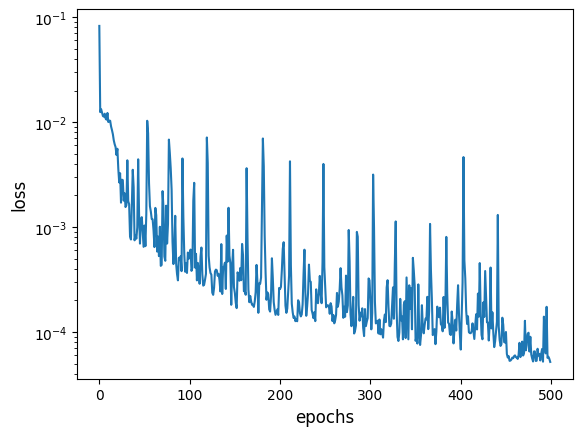

In [22]:
plt.semilogy(hist.history['loss'])
plt.xlabel('epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
#plt.savefig("./Fig/loss_adam_tomo_over_sigma5.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

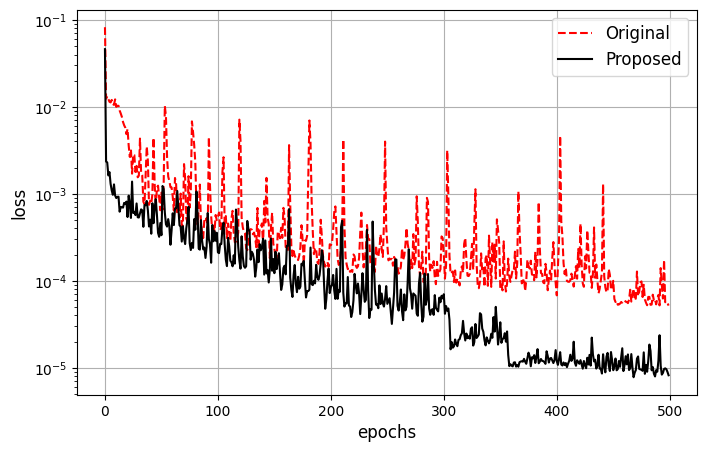

In [23]:
loss_tomo_ori = hist.history['loss']
np.save('./loss_tomo_over_random_ori_noi%d.npy'%(epoch_num),loss_tomo_ori)

loss_tomo_new = np.load('./loss_tomo_over_random_new%d.npy'%(epoch_num))
plt.style.use('default')

plt.figure(figsize=(8,5))

ax = plt.gca()
plt.semilogy(loss_tomo_ori[::1],'r--')
plt.semilogy(loss_tomo_new[::1],'k')
plt.xlabel('epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(['Original','Proposed'], fontsize=12)
plt.grid()
# plt.savefig("./Fig/loss_comp_over_crosswell_random.jpeg", format='jpeg', bbox_inches="tight",dpi=400)


In [24]:
vp_s = velpmodel[np.round(SZ/deltaz).astype(int),np.round(SX/deltax).astype(int),0] # Velocity at the source location
vs_s = velsmodel[np.round(SZ/deltaz).astype(int),np.round(SX/deltax).astype(int),0]

Tp0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vp_s;
Ts0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vs_s;

pxp0 = np.divide(X-SX, Tp0*vp_s**2, out=np.zeros_like(Tp0), where=Tp0!=0)
pzp0 = np.divide(Z-SZ, Tp0*vp_s**2, out=np.zeros_like(Tp0), where=Tp0!=0)

pxs0 = np.divide(X-SX, Ts0*vs_s**2, out=np.zeros_like(Ts0), where=Ts0!=0)
pzs0 = np.divide(Z-SZ, Ts0*vs_s**2, out=np.zeros_like(Ts0), where=Ts0!=0)

pxp0 = pxp0.reshape(-1,1)
pzp0 = pzp0.reshape(-1,1)
Tp0 = Tp0.reshape(-1,1)

pxs0 = pxs0.reshape(-1,1)
pzs0 = pzs0.reshape(-1,1)
Ts0 = Ts0.reshape(-1,1)

test_data = X_star + [pzp0,pxp0,Tp0] + [pzs0,pxs0,Ts0]

taup_pred = taup.eval(model, test_data)
Tp_pred = taup_pred*Tp0
taup_pred = taup_pred.reshape(Z.shape)
Tp_pred = Tp_pred.reshape(Z.shape)
np.save('./over_pinntomo_taup_pred_random_ori%d.npy'%(epoch_num),taup_pred)
np.save('./over_pinntomo_Tppred_random_ori%d.npy'%(epoch_num),Tp_pred)

taus_pred = taus.eval(model, test_data)
Ts_pred = taus_pred*Ts0
taus_pred = taus_pred.reshape(Z.shape)
Ts_pred = Ts_pred.reshape(Z.shape)
np.save('./over_pinntomo_taus_pred_random_ori%d.npy'%(epoch_num),taus_pred)
np.save('./over_pinntomo_Tppred_random_ori%d.npy'%(epoch_num),Tp_pred)

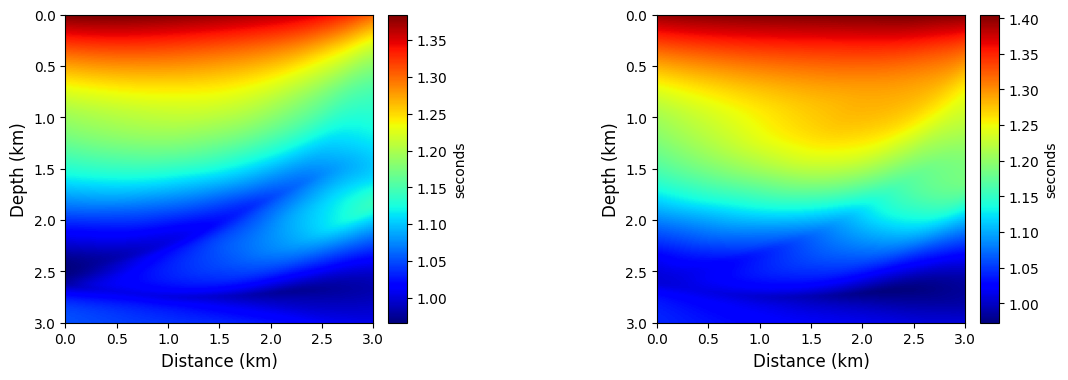

In [25]:
isou = 13
plt.style.use('default')

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(taup_pred[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(taus_pred[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./Fig/taup_taus_pred_tomo_over_ori.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

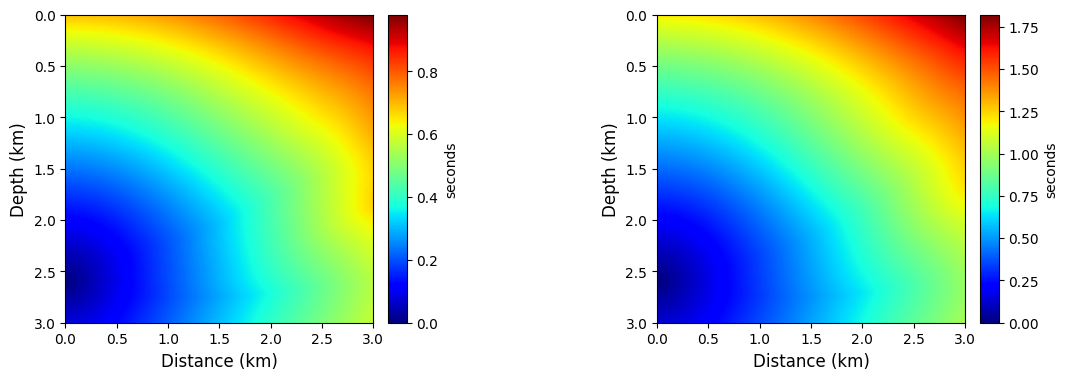

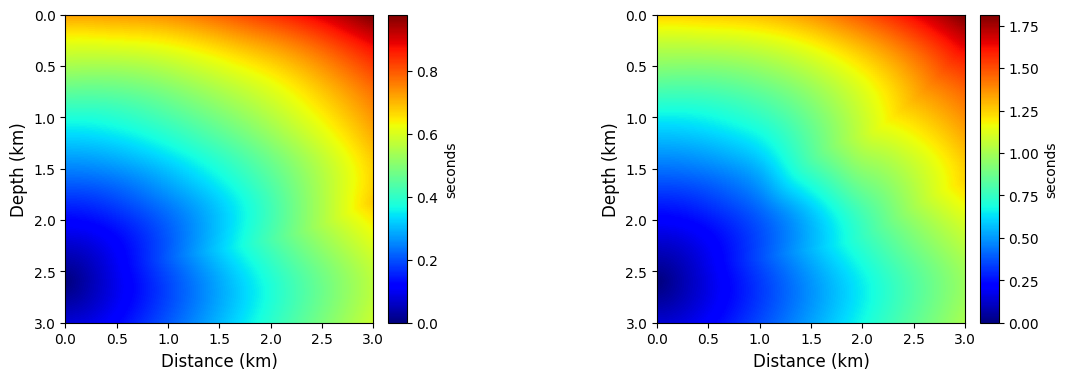

In [26]:
# Plot the PINN solution error
plt.style.use('default')

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(Tp_pred[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(Ts_pred[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)
#plt.savefig("./Fig/Tp_Ts_true_tomodd_sigma5.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

plt.style.use('default')

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(Tp_data.reshape(Z.shape)[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(Ts_data.reshape(Z.shape)[:,:,isou], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./Fig/Tp_Ts_pred_tomo_over_sigma5_wrongbg_R.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

In [27]:
vp_pred = vp.eval(model, test_data)
vp_pred = vp_pred.reshape(Z.shape)
np.save('./over_pinntomo_vppred_random_ori_noi%d.npy'%(epoch_num),vp_pred)

vs_pred = vs.eval(model, test_data)
vs_pred = vs_pred.reshape(Z.shape)
np.save('./over_pinntomo_vspred_random_ori_noi%d.npy'%(epoch_num),vs_pred)

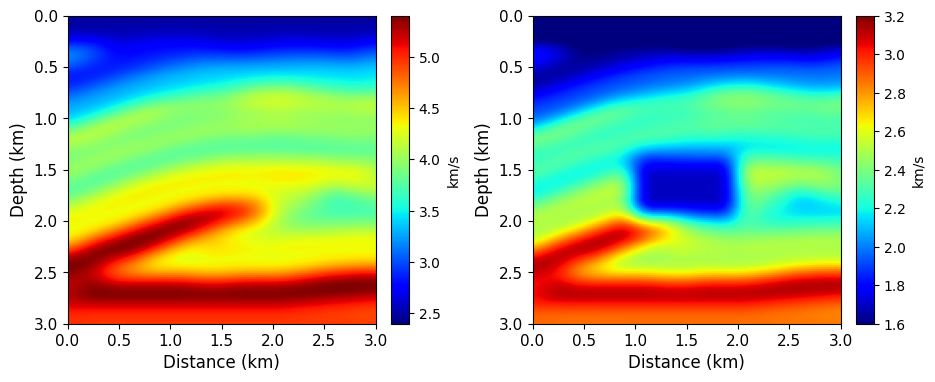

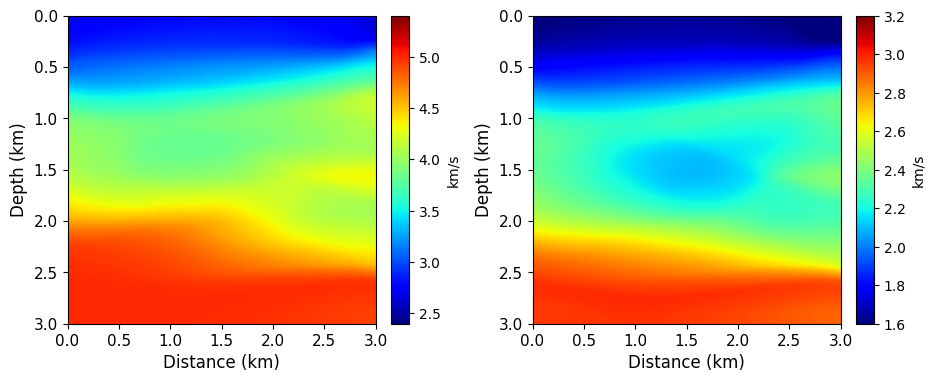

In [28]:

# Plot the velocity model with the source location
plt.style.use('default')

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(vp_true, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(2.4,5.4)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(vs_true, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.6,3.2)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./Fig/v_true_over_sigma5.jpeg", format='jpeg', bbox_inches="tight")

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
ax = plt.gca()
im = ax.imshow(vp_pred[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(2.4,5.4)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(vs_pred[:,:,0], extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Distance (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Depth (km)', fontsize=12)
plt.yticks(fontsize=11)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.mappable.set_clim(1.6,3.2)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./Fig/over_vp_vs_pred_tomo_random_ori_noi%d.jpeg"%(epoch_num), format='jpeg', bbox_inches="tight",dpi=400)